In [1]:
import os
import pandas as pd
import numpy as np
import json
import pprint
import re
import nltk
import csv
import sys

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data_dir = "data"
data_folders = os.listdir(data_dir)

for data_folder in data_folders:
    print(data_folder,'\n',os.listdir(os.path.join(data_dir,data_folder)))
    print('-'*30)

empatheticdialogues 
 ['test.csv', 'train.csv', 'valid.csv']
------------------------------
goemotions 
 ['goemotions_1.csv', 'goemotions_2.csv', 'goemotions_3.csv']
------------------------------
processed 
 ['ed_for_goemotions.tsv', 'all_dd_data.tsv', 'all_meld_data.tsv', 'all_names.csv', 'dd_for_goemotions.tsv', 'meld_for_goemotions.tsv', 'dd_for_goemotions.tsv.eval_results.txt', 'dd_for_goemotions.tsv.label_predictions.tsv', 'dd_for_goemotions.tsv.predictions.tsv', 'dd_for_goemotions.tsv.tf_record', 'meld_for_goemotions.tsv.eval_results.txt', 'meld_for_goemotions.tsv.label_predictions.tsv', 'meld_for_goemotions.tsv.predictions.tsv', 'meld_for_goemotions.tsv.tf_record', 'emotions.csv', 'dd_goemotions_pred_broad.tsv', 'dd_goemotions_pred_broad_simple.tsv', 'meld_goemotions_pred_broad_simple.tsv', 'ed_train_clean.csv', 'ed_test_clean.csv', 'ed_valid_clean.csv', 'ed_goemotions_pred_broad_simple.tsv', 'all_ed_data.tsv', 'ed_for_goemotions.tsv.eval_results.txt', 'ed_for_goemotions.tsv.la

In [3]:
emotion_codes = ("neutral", "anger", "disgust", "fear", "joy", "sadness", "surprise")

In [4]:
data_folder='processed'
file_name='emotions.csv'
emotions = pd.read_csv(os.path.join(data_dir, data_folder, file_name))
print(emotions.shape)

emotions

(28, 6)


,fine_emo,fine_emo_id,broad_emo,broad_emo_id,sentiment,sentiment_id
0,admiration,0,joy,4,positive,3
1,amusement,1,joy,4,positive,3
2,anger,2,anger,1,negative,1
3,annoyance,3,anger,1,negative,1
4,approval,4,joy,4,positive,3
5,caring,5,joy,4,positive,3
6,confusion,6,surprise,6,ambiguous,2
7,curiosity,7,surprise,6,ambiguous,2
8,desire,8,joy,4,positive,3
9,disappointment,9,sadness,5,negative,1


### DD Data Pairing

In [5]:
file_name='dd_goemotions_pred_broad_simple.tsv'
dd_data = pd.read_csv(os.path.join(data_dir, data_folder, file_name), sep='\t')
print(dd_data.shape)
dd_data.head()

(102979, 5)


,utterance,label,id,pred,pred_broad_id
0,The kitchen stinks.,2,1_1,neutral,0
1,I 'll throw out the garbage.,0,1_2,neutral,0
2,"So [NAME], how about getting some coffee for t...",4,2_1,curiosity,6
3,Coffee? I don't honestly like that kind of stuff.,2,2_2,curiosity,6
4,"Come on, you can at least try a little, beside...",0,2_3,neutral,0


In [6]:
file_name='all_dd_data.tsv'
all_dd_data = pd.read_csv(os.path.join(data_dir, data_folder, file_name), sep='\t')
print(all_dd_data.shape)
all_dd_data.head()

(102979, 6)


,convo_idx,topic,utterance_idx,utterance,act_label,emotion_label
0,1,1,1,The kitchen stinks.,3,2
1,1,1,2,I 'll throw out the garbage.,4,0
2,2,1,1,"So [NAME], how about getting some coffee for t...",3,4
3,2,1,2,Coffee? I don't honestly like that kind of stuff.,4,2
4,2,1,3,"Come on, you can at least try a little, beside...",3,0


In [7]:
dd_data["convo_id"] = all_dd_data["convo_idx"]
dd_data["utterance_id"] = all_dd_data["utterance_idx"]

dd_data.head()

,utterance,label,id,pred,pred_broad_id,convo_id,utterance_id
0,The kitchen stinks.,2,1_1,neutral,0,1,1
1,I 'll throw out the garbage.,0,1_2,neutral,0,1,2
2,"So [NAME], how about getting some coffee for t...",4,2_1,curiosity,6,2,1
3,Coffee? I don't honestly like that kind of stuff.,2,2_2,curiosity,6,2,2
4,"Come on, you can at least try a little, beside...",0,2_3,neutral,0,2,3


In [8]:
## For each utterance, get the response (next utterance) data
dd_data["next_utter_id"] = dd_data["utterance_id"].shift(-1).fillna(0).astype(int)
dd_data["next_utter"] = dd_data["utterance"].shift(-1).fillna("")
dd_data["next_utter_label"] = dd_data["label"].shift(-1).fillna(-1).astype(int)
dd_data["next_utter_pred"] = dd_data["pred"].shift(-1).fillna("end_convo")

## Make sure end of conversations are properly labelled
dd_data['end_convo'] = dd_data['next_utter_id'] < dd_data['utterance_id']
dd_data.loc[dd_data['end_convo'] == True, 'next_utter'] = ""
dd_data.loc[dd_data['end_convo'] == True, 'next_utter_id'] = 0
dd_data.loc[dd_data['end_convo'] == True, 'next_utter_label'] = -1
dd_data.loc[dd_data['end_convo'] == True, 'next_utter_pred'] = "end_convo"

dd_data

,utterance,label,id,pred,pred_broad_id,convo_id,utterance_id,next_utter_id,next_utter,next_utter_label,next_utter_pred,end_convo
0,The kitchen stinks.,2,1_1,neutral,0,1,1,2,I 'll throw out the garbage.,0,neutral,False
1,I 'll throw out the garbage.,0,1_2,neutral,0,1,2,0,,-1,end_convo,True
2,"So [NAME], how about getting some coffee for t...",4,2_1,curiosity,6,2,1,2,Coffee? I don't honestly like that kind of stuff.,2,curiosity,False
3,Coffee? I don't honestly like that kind of stuff.,2,2_2,curiosity,6,2,2,3,"Come on, you can at least try a little, beside...",0,neutral,False
4,"Come on, you can at least try a little, beside...",0,2_3,neutral,0,2,3,4,What's wrong with that? Cigarette is the thing...,1,curiosity,False
...,...,...,...,...,...,...,...,...,...,...,...,...
102974,"Well, thank you very much for all that informa...",0,13118_11,gratitude,4,13118,11,12,Are you going to make an offer today?,0,curiosity,False
102975,Are you going to make an offer today?,0,13118_12,curiosity,6,13118,12,13,Yes. My customer is in urgent need of the stee...,0,neutral,False
102976,Yes. My customer is in urgent need of the stee...,0,13118_13,neutral,0,13118,13,14,"Ok, I 'll get this rate right away.",0,optimism,False
102977,"Ok, I 'll get this rate right away.",0,13118_14,optimism,4,13118,14,15,Thank you.,4,gratitude,False


In [9]:
## Get label counts for emotional responses
dd_pairs_broad = dd_data.groupby(['label', 'next_utter_label']).agg({'next_utter_label':'count'}).unstack().fillna(0)
dd_pairs_broad = dd_pairs_broad.astype(int)

dd_pairs_broad.columns = ["end_convo", "neutral", "anger", "disgust", "fear", "joy", "sadness", "surprise"]
dd_pairs_broad.index = ["neutral", "anger", "disgust", "fear", "joy", "sadness", "surprise"]

dd_pairs_broad

,end_convo,neutral,anger,disgust,fear,joy,sadness,surprise
neutral,8970,67606,677,223,125,5683,887,1401
anger,156,686,108,3,1,11,40,17
disgust,51,238,5,42,0,5,2,10
fear,17,136,0,0,5,8,0,8
joy,3578,3196,8,11,7,5898,18,169
sadness,172,789,34,1,1,45,65,43
surprise,174,1346,23,11,6,179,24,60


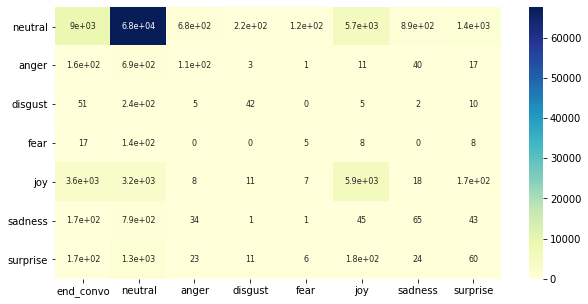

In [63]:
plt.figure(figsize=(10,5))
sns.heatmap(dd_pairs_broad, cmap="YlGnBu", annot=True, annot_kws={"size": 8})

In [10]:
row_sums = dd_pairs_broad.sum(axis=1)
row_sums

neutral     85572
anger        1022
disgust       353
fear          174
joy         12885
sadness      1150
surprise     1823
dtype: int64

In [11]:
pct = dd_pairs_broad.div(row_sums, axis=0)
pct

,end_convo,neutral,anger,disgust,fear,joy,sadness,surprise
neutral,0.104824,0.790048,0.007911,0.002606,0.001461,0.066412,0.010366,0.016372
anger,0.152642,0.671233,0.105675,0.002935,0.000978,0.010763,0.039139,0.016634
disgust,0.144476,0.674221,0.014164,0.118980,0.000000,0.014164,0.005666,0.028329
fear,0.097701,0.781609,0.000000,0.000000,0.028736,0.045977,0.000000,0.045977
joy,0.277687,0.248040,0.000621,0.000854,0.000543,0.457742,0.001397,0.013116
sadness,0.149565,0.686087,0.029565,0.000870,0.000870,0.039130,0.056522,0.037391
surprise,0.095447,0.738343,0.012617,0.006034,0.003291,0.098190,0.013165,0.032913


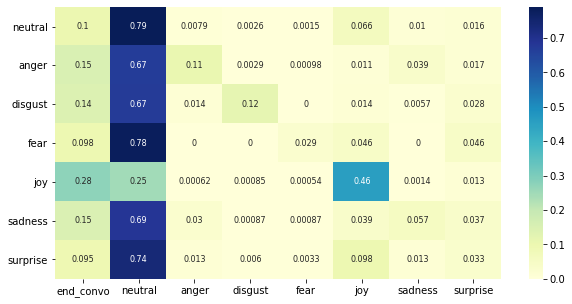

In [64]:
plt.figure(figsize=(10,5))
sns.heatmap(pct, cmap="YlGnBu", annot=True, annot_kws={"size": 8})

In [66]:
## Get label counts for emotional responses
dd_pairs_fine = dd_data.groupby(['pred', 'next_utter_pred']).agg({'next_utter_pred':'count'}).unstack().fillna(0)
dd_pairs_fine = dd_pairs_fine.astype(int)

dd_pairs_fine

next_utter_pred                                               \
next_utter_pred      admiration amusement anger annoyance approval confusion   
pred                                                                           
admiration                  699        33     6         1      239         4   
amusement                    31        21     2         0       15         0   
anger                         4         0     0         0        7         1   
annoyance                     0         0     0         0        0         0   
approval                    251        14     4         0      105         2   
confusion                     8         0     0         0        4         0   
curiosity                  1569        93    20         1     1086        61   
desire                       46         3     1         0       25         1   
excitement                    1         0     0         0        1         0   
gratitude                   240         5     3         0       72         5   
joy                         139         6     0         0       59         0   
love                        152         7     2         0       40         2   
neutral                    2964       139    77         7     1543        50   
optimism                    127         3     2         0       45         3   
remorse                      43         4     2         1       56         1   
sadness                      39         6     1         0       39         2   
surprise                     50         6     0         0       35         1   

                                                                           \
next_utter_pred curiosity desire end_convo excitement gratitude  joy love   
pred                                                                        
admiration           1245     32      1159          1       401  161  106   
amusement              60      1        53          0         7   13    8   
anger                  27      0        24          0         2    0    2   
annoyance               2      0         1          0         0    0    1   
approval              829      9       687          2       171   43   37   
confusion              32      0        13          0         2    6    2   
curiosity            2969    315       484         10       481  349  492   
desire                264      2        52          0        11    7    6   
excitement              6      2         8          0         0    1    5   
gratitude             467     10      1859          1       504   81   33   
joy                   274      9       292          2       122   76   20   
love                  364      2       147          0        33   24   63   
neutral             12272    243      7203         15      2245  540  453   
optimism              242      9       686          1       271   29   17   
remorse               305      6       229          0        88   10    8   
sadness               286      2       132          1        30   10    5   
surprise              133      2        89          0         9   14   14   

                                                           
next_utter_pred neutral optimism remorse sadness surprise  
pred                                                       
admiration         2591      163      43      34       41  
amusement           132        4       6       3        1  
anger                71        4       5       5        1  
annoyance             5        0       1       0        0  
approval           1204       93      45      22       19  
confusion            76        6       2       2        1  
curiosity         16598      380     349     333      117  
desire              335       28      12       4        1  
excitement           13        0       0       0        0  
gratitude          1119      143      27      13        9  
joy                 481       29      24      14        7  
love                511       25  

In [39]:
## Play around with different emotion pairings
selected = dd_data[dd_data["label"] == 0]
selected = selected[selected["next_utter_label"].isin([0])]
selected

,utterance,label,id,pred,pred_broad_id,convo_id,utterance_id,next_utter_id,next_utter,next_utter_label,next_utter_pred,end_convo
9,"[NAME], I really think you're beating around t...",0,3_3,admiration,4,3,3,4,You're right. Everything is probably going to ...,0,approval,False
11,Would you mind waiting a while?,0,4_1,neutral,0,4,1,2,"Well, how long will it be?",0,curiosity,False
12,"Well, how long will it be?",0,4_2,curiosity,6,4,2,3,I 'm not sure. But I 'll get a table ready as ...,0,neutral,False
22,"Oh, no, get off it. It wasn't such a killer cl...",0,6_5,neutral,0,6,5,6,I am wiped out. Thank you.,0,gratitude,False
23,I am wiped out. Thank you.,0,6_6,gratitude,4,6,6,7,"Look, next time get yourself some comfy shoes....",0,neutral,False
...,...,...,...,...,...,...,...,...,...,...,...,...
102972,Are there any other clauses in marine policies?,0,13118_9,curiosity,6,13118,9,10,"Oh, lots of them. For instance, War Risks, TEN...",0,neutral,False
102973,"Oh, lots of them. For instance, War Risks, TEN...",0,13118_10,neutral,0,13118,10,11,"Well, thank you very much for all that informa...",0,gratitude,False
102974,"Well, thank you very much for all that informa...",0,13118_11,gratitude,4,13118,11,12,Are you going to make an offer today?,0,curiosity,False
102975,Are you going to make an offer today?,0,13118_12,curiosity,6,13118,12,13,Yes. My customer is in urgent need of the stee...,0,neutral,False


In [104]:
## Play around with different emotion pairings
selected = dd_data[dd_data["pred"] == "neutral"]
selected = selected[selected["next_utter_pred"].isin(["neutral"])]
selected

,utterance,label,id,pred,pred_broad_id,convo_id,utterance_id,next_utter_id,next_utter,next_utter_label,next_utter_pred,end_convo
0,The kitchen stinks.,2,1_1,neutral,0,1,1,2,I 'll throw out the garbage.,0,neutral,False
7,Are things still going badly with your housegu...,0,3_1,neutral,0,3,1,2,Getting worse. Now he's eating me out of house...,1,neutral,False
13,I 'm not sure. But I 'll get a table ready as ...,0,4_3,neutral,0,4,3,4,OK. We 'll wait.,4,neutral,False
28,"Well, I want a fillet steak, medium, but my li...",0,7_2,neutral,0,7,2,3,Certainly. How about spaghetti with clams and ...,0,neutral,False
36,According to some studies it may cause cancer.,0,8_6,neutral,0,8,6,7,"Oh, do n't let that worry you. If that were tr...",0,neutral,False
...,...,...,...,...,...,...,...,...,...,...,...,...
102966,Now we 've given a CIF Shanghai price for some...,0,13118_3,neutral,0,13118,3,4,"Well. Obviously, you won't want All Risks cover.",0,neutral,False
102967,"Well. Obviously, you won't want All Risks cover.",0,13118_4,neutral,0,13118,4,5,Why not?,0,neutral,False
102968,Why not?,0,13118_5,neutral,0,13118,5,6,Because they aren't delicate goods and won't l...,0,neutral,False
102969,Because they aren't delicate goods and won't l...,0,13118_6,neutral,0,13118,6,7,Then am I right in understanding that FPA does...,0,neutral,False


### ED Data Pairing

In [14]:
file_name='ed_goemotions_pred_broad_simple.tsv'
ed_data = pd.read_csv(os.path.join(data_dir, data_folder, file_name), sep='\t')
print(ed_data.shape)
ed_data.head()

(84169, 5)


,utterance,label,id,pred,pred_broad_id
0,I remember going to see the fireworks with my ...,0,1_1,0,4
1,"Was this a friend you were in love with, or ju...",0,1_2,18,4
2,This was a best friend. I miss her.,0,1_3,4,4
3,Where has she gone?,0,1_4,7,6
4,We no longer talk.,0,1_5,27,0


In [15]:
file_name='all_ed_data.tsv'
all_ed_data = pd.read_csv(os.path.join(data_dir, data_folder, file_name), sep='\t')
print(all_ed_data.shape)
all_ed_data.head()

(84169, 9)


,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags,conv_num
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN,1
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN,1
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN,1
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN,1
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN,1


In [73]:
ed_data["convo_id"] = all_ed_data["conv_num"]
ed_data["utterance_id"] = all_ed_data["utterance_idx"]
ed_data["context"] = all_ed_data["context"]

ed_data.head(10)

,utterance,label,id,pred,pred_broad_id,convo_id,utterance_id,next_utter_id,next_utter,next_utter_broad,next_utter_pred,end_convo,context
0,I remember going to see the fireworks with my ...,0,1_1,0,4,1,1,2,"Was this a friend you were in love with, or ju...",4,18,False,sentimental
1,"Was this a friend you were in love with, or ju...",0,1_2,18,4,1,2,3,This was a best friend. I miss her.,4,4,False,sentimental
2,This was a best friend. I miss her.,0,1_3,4,4,1,3,4,Where has she gone?,6,7,False,sentimental
3,Where has she gone?,0,1_4,7,6,1,4,5,We no longer talk.,0,27,False,sentimental
4,We no longer talk.,0,1_5,27,0,1,5,6,Oh was this something that happened because of...,6,7,False,sentimental
5,Oh was this something that happened because of...,0,1_6,7,6,1,6,0,,-1,-1,True,sentimental
6,it feels like hitting to blank wall when i se...,0,2_1,27,0,2,1,2,Oh ya? I don't really see how,6,7,False,afraid
7,Oh ya? I don't really see how,0,2_2,7,6,2,2,3,dont you feel so.. its a wonder,6,26,False,afraid
8,dont you feel so.. its a wonder,0,2_3,26,6,2,3,4,I do actually hit blank walls a lot of times b...,0,27,False,afraid
9,I do actually hit blank walls a lot of times b...,0,2_4,27,0,2,4,5,i virtually thought so.. and i used to get sw...,0,27,False,afraid


In [17]:
## For each utterance, get the response (next utterance) data
ed_data["next_utter_id"] = ed_data["utterance_id"].shift(-1).fillna(0).astype(int)
ed_data["next_utter"] = ed_data["utterance"].shift(-1).fillna("")
ed_data["next_utter_broad"] = ed_data["pred_broad_id"].shift(-1).fillna(-1).astype(int)
ed_data["next_utter_pred"] = ed_data["pred"].shift(-1).fillna(-1).astype(int)

## Make sure end of conversations are properly labelled
ed_data['end_convo'] = ed_data['next_utter_id'] < ed_data['utterance_id']
ed_data.loc[ed_data['end_convo'] == True, 'next_utter'] = ""
ed_data.loc[ed_data['end_convo'] == True, 'next_utter_id'] = 0
ed_data.loc[ed_data['end_convo'] == True, 'next_utter_broad'] = -1
ed_data.loc[ed_data['end_convo'] == True, 'next_utter_pred'] = -1

ed_data

,utterance,label,id,pred,pred_broad_id,convo_id,utterance_id,next_utter_id,next_utter,next_utter_broad,next_utter_pred,end_convo
0,I remember going to see the fireworks with my ...,0,1_1,0,4,1,1,2,"Was this a friend you were in love with, or ju...",4,18,False
1,"Was this a friend you were in love with, or ju...",0,1_2,18,4,1,2,3,This was a best friend. I miss her.,4,4,False
2,This was a best friend. I miss her.,0,1_3,4,4,1,3,4,Where has she gone?,6,7,False
3,Where has she gone?,0,1_4,7,6,1,4,5,We no longer talk.,0,27,False
4,We no longer talk.,0,1_5,27,0,1,5,6,Oh was this something that happened because of...,6,7,False
...,...,...,...,...,...,...,...,...,...,...,...,...
84164,Yeah reminds me of the good old days. I miss m...,0,24848_5,27,0,24848,5,0,,-1,-1,True
84165,I woke up this morning to my wife telling me s...,0,24849_1,17,4,24849,1,2,Oh hey that's awesome! That is awesome right?,4,0,False
84166,Oh hey that's awesome! That is awesome right?,0,24849_2,0,4,24849,2,3,It is soooo awesome. We have been wanting a ba...,4,0,False
84167,It is soooo awesome. We have been wanting a ba...,0,24849_3,0,4,24849,3,4,That is awesome!!!! Congratulations!,4,0,False


In [18]:
ed_data.pred_broad_id.value_counts()

0    34543
4    31907
6    11369
5     5866
1      484
Name: pred_broad_id, dtype: int64

In [19]:
## Get broad emotion counts for emotional responses
ed_pairs = ed_data.groupby(['pred_broad_id', 'next_utter_broad']).agg({'next_utter_broad':'count'}).unstack().fillna(0)
ed_pairs = ed_pairs.astype(int)

 ## nothing predicted for disgust and fear
ed_pairs.columns = ["end_convo", "neutral", "anger", "joy", "sadness", "surprise"]
ed_pairs.index = ["neutral", "anger", "joy", "sadness", "surprise"]

ed_pairs

,end_convo,neutral,anger,joy,sadness,surprise
neutral,6955,9690,190,9759,1935,6014
anger,70,212,12,90,34,66
joy,9475,6695,42,12099,693,2903
sadness,974,1810,35,1311,744,992
surprise,2057,5429,52,2654,543,634


In [37]:
## Play around with different emotion pairings
selected = ed_data[ed_data["pred_broad_id"] == 6]
selected = selected[selected["next_utter_broad"].isin([-1, 6])]
selected

,utterance,label,id,pred,pred_broad_id,convo_id,utterance_id,next_utter_id,next_utter,next_utter_broad,next_utter_pred,end_convo
5,Oh was this something that happened because of...,0,1_6,7,6,1,6,0,,-1,-1,True
7,Oh ya? I don't really see how,0,2_2,7,6,2,2,3,dont you feel so.. its a wonder,6,26,False
11,Wait what are sweatings,0,2_6,7,6,2,6,0,,-1,-1,True
20,What do you mean it hasn't been easy? How clos...,0,4_4,7,6,4,4,0,,-1,-1,True
93,so what have you done?,0,27_5,7,6,27,5,0,,-1,-1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
83748,"No, I'm sure I'm a bit older than you.",0,24733_4,7,6,24733,4,0,,-1,-1,True
83805,I found myself shocked today by my roommate.,0,24748_1,26,6,24748,1,2,What did they do?,6,7,False
83859,"Those are so tasty, are you excited?",0,24762_4,26,6,24762,4,0,,-1,-1,True
83864,I'm not sure if my boyfriend wants to get marr...,0,24764_1,7,6,24764,1,2,"Communication is key, have you talked to him a...",6,7,False


In [21]:
## Get broad emotion counts for emotional responses
ed_pairs = ed_data.groupby(['pred', 'next_utter_pred']).agg({'next_utter_pred':'count'}).unstack().fillna(0)
ed_pairs = ed_pairs.astype(int)

## Get the word labels
ed_pairs.columns = ["end_convo"] + [emotions.fine_emo[x] for x in emotions.index.tolist() if x in ed_pairs.index.tolist()]
ed_pairs.index = [emotions.fine_emo[x] for x in emotions.index.tolist() if x in ed_pairs.index.tolist()]

ed_pairs

,end_convo,admiration,amusement,anger,annoyance,approval,confusion,curiosity,desire,excitement,gratitude,joy,love,optimism,remorse,sadness,surprise,neutral
admiration,3146,1905,307,7,1,541,7,682,76,13,413,507,315,399,68,113,143,2499
amusement,964,224,274,3,1,96,3,141,18,2,16,85,53,103,36,60,32,691
anger,62,10,16,11,0,22,3,51,2,0,4,8,7,14,14,17,5,200
annoyance,8,0,3,1,0,1,0,7,1,0,0,1,0,1,2,1,0,12
approval,1027,777,128,10,0,156,15,583,22,3,94,171,92,321,84,73,94,990
confusion,37,6,5,1,1,9,1,12,1,0,2,3,4,12,3,19,2,122
curiosity,1660,554,285,40,1,464,17,227,61,7,68,217,152,172,67,384,94,4755
desire,167,62,22,1,0,27,1,77,12,0,8,13,11,52,19,11,3,198
excitement,18,19,5,0,0,2,0,30,0,0,1,4,3,6,0,1,4,28
gratitude,630,227,42,3,0,78,1,101,13,0,96,85,30,136,14,13,13,386


In [93]:
context_counts = ed_data["context"].value_counts()
context_counts

surprised       4310
excited         3218
angry           2991
proud           2933
sad             2883
annoyed         2880
lonely          2751
grateful        2736
afraid          2728
terrified       2708
guilty          2675
disgusted       2663
furious         2663
confident       2657
anxious         2651
hopeful         2638
anticipating    2632
impressed       2630
nostalgic       2595
disappointed    2567
joyful          2555
jealous         2540
prepared        2529
content         2479
devastated      2425
embarrassed     2407
sentimental     2298
caring          2292
trusting        2270
ashamed         2191
apprehensive    2014
faithful        1660
Name: context, dtype: int64

In [90]:
by_context = ed_data.groupby(['context', "pred"]).agg(
    {'pred':'count'}).unstack().fillna(0).astype(int)
by_context.columns = ed_pairs.index
by_context

,admiration,amusement,anger,annoyance,approval,confusion,curiosity,desire,excitement,gratitude,joy,love,optimism,remorse,sadness,surprise,neutral
context,,,,,,,,,,,,,,,,,
afraid,94,103,13,1,123,15,399,9,1,34,68,18,150,34,382,52,1232
angry,87,71,84,8,113,20,401,23,0,23,59,23,131,83,124,47,1694
annoyed,75,98,74,8,124,15,355,20,0,18,43,23,127,62,86,30,1722
anticipating,397,98,3,0,166,0,300,18,27,74,261,114,178,14,22,100,860
anxious,205,66,15,1,186,10,314,23,4,65,118,36,235,32,162,50,1129
apprehensive,149,52,3,1,139,8,258,19,2,45,66,28,133,25,124,27,935
ashamed,98,108,3,2,128,8,285,17,2,32,42,19,102,87,172,36,1050
caring,430,48,2,0,118,3,215,21,1,69,115,183,131,47,98,22,789
confident,631,74,1,0,262,2,248,20,3,111,103,64,210,10,25,39,854


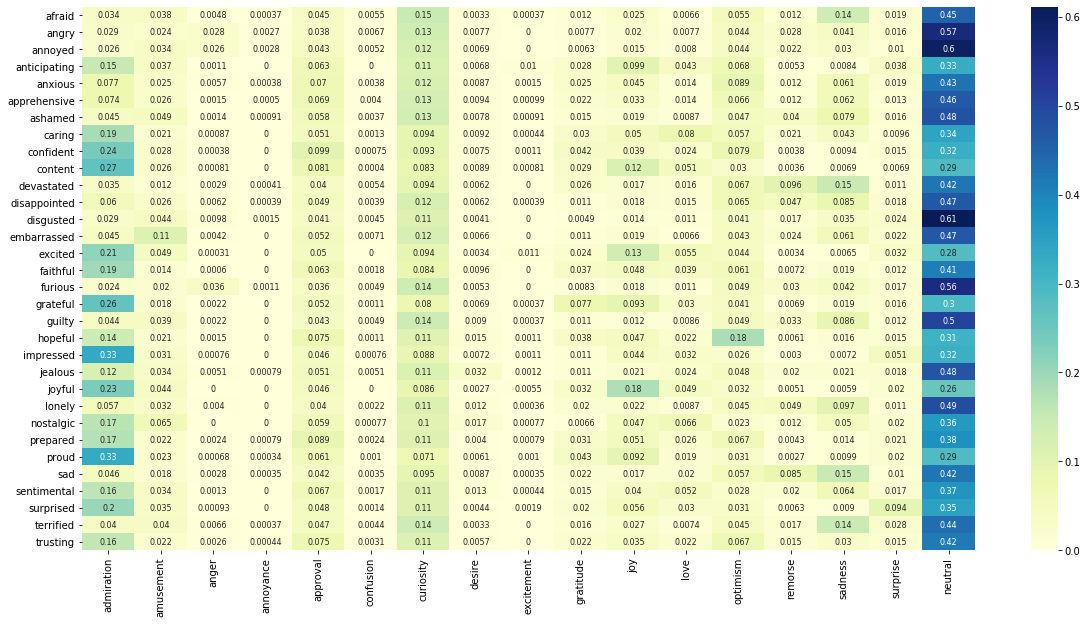

In [97]:
pct = by_context.div(context_counts, axis=0)

plt.figure(figsize=(20,10))
sns.heatmap(pct, cmap="YlGnBu", annot=True, annot_kws={"size": 8})

In [87]:
by_context = ed_data.groupby(['context', "pred_broad_id"]).agg(
    {'pred_broad_id':'count'}).unstack().fillna(0).astype(int)
by_context.columns = ["neutral", "anger", "joy", "sadness", "surprise"]
by_context

,neutral,anger,joy,sadness,surprise
context,,,,,
afraid,1232,14,600,416,466
angry,1694,92,530,207,468
annoyed,1722,82,528,148,400
anticipating,860,3,1333,36,400
anxious,1129,16,938,194,374
apprehensive,935,4,633,149,293
ashamed,1050,5,548,259,329
caring,789,2,1116,145,240
confident,854,1,1478,35,289


In [412]:
len(by_context)

32

In [88]:
## Play around with different contexts
selected = ed_data[ed_data["context"] == "afraid"]
selected = selected[selected["pred"].isin([17])]
selected

,utterance,label,id,pred,pred_broad_id,convo_id,utterance_id,next_utter_id,next_utter,next_utter_broad,next_utter_pred,end_convo,context
69,So happy everyone was fine!! Everything else c...,0,22_4,17,4,22,4,5,Indeed. We were out of the house for five mont...,0,27,False,afraid
208,"Oh No, well glad to see you are here still!",0,52_4,17,4,52,4,5,Luckily,4,17,False,afraid
209,Luckily,0,52_5,17,4,52,5,0,,-1,-1,True,afraid
608,Im glad you are ok. Some of those are poisonou...,0,147_4,17,4,147,4,0,,-1,-1,True,afraid
1234,i'm so glad you did'nt get hurt,0,308_4,17,4,308,4,5,"Me too, that would have been brutal",0,27,False,afraid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68719,So I was finally convinced to try rock climbin...,0,19950_1,17,4,19950,1,2,Are you nervous about it? Hope it goes well.,4,20,False,afraid
73627,I am glad you escaped it,0,21690_4,17,4,21690,4,5,"Me too. I don't even believe in ghosts, I just...",0,27,False,afraid
80082,Oh haha when you say pit bull i immediately th...,0,23616_4,17,4,23616,4,0,,-1,-1,True,afraid
82183,I am happy that you reached home safely. You h...,0,24251_2,17,4,24251,2,3,I felt so scared. Im just glad I noticed them ...,4,4,False,afraid


In [22]:
reference = pd.DataFrame(ed_data["pred"].value_counts())
reference["emotion"] = [emotions.fine_emo[x] for x in reference.index.tolist() if x in emotions.index.tolist()]
reference.sort_values(by="emotion")

,pred,emotion
0,11142,admiration
1,2802,amusement
2,446,anger
3,38,annoyance
4,4640,approval
6,240,confusion
7,9225,curiosity
8,684,desire
13,121,excitement
15,1868,gratitude


In [71]:
## Play around
selected = ed_data[ed_data["pred"] == 7]
selected = selected[selected["next_utter_pred"].isin([7])]
selected

,utterance,label,id,pred,pred_broad_id,convo_id,utterance_id,next_utter_id,next_utter,next_utter_broad,next_utter_pred,end_convo
131,Do you have any irritating coworkers?,0,35_1,7,6,35,1,2,"Yes, I think that everyone does! What about you?",6,7,False
282,Did you go outside and see if anyone was hurt?,0,72_1,7,6,72,1,2,What do you mean? I don't know what you are ta...,6,7,False
681,Do you usually get a live one ?,0,164_2,7,6,164,2,3,"I thought about it, but dont think I could han...",6,7,False
912,I said I did not know where my friend was.,0,220_3,7,6,220,3,4,Did your friend do something bad? Why were the...,6,7,False
1674,Ever have those days when everything just goes...,0,451_1,7,6,451,1,2,"Yes, many. Would you like to tell me about it?",6,7,False
...,...,...,...,...,...,...,...,...,...,...,...,...
83315,I stole money from my daughter's piggy bank an...,0,24606_1,7,6,24606,1,2,"Oh no, what did you buy?",6,7,False
83746,Is that a game ?,0,24733_2,7,6,24733,2,3,"It is, you have never heard of it?",6,7,False
83747,"It is, you have never heard of it?",0,24733_3,7,6,24733,3,4,"No, I'm sure I'm a bit older than you.",6,7,False
83864,I'm not sure if my boyfriend wants to get marr...,0,24764_1,7,6,24764,1,2,"Communication is key, have you talked to him a...",6,7,False


#### Filter out ED data that has both parties surprised (surprised/confused/curious) or conversations that end with one party being surprised (surprised/confused/curious)

In [24]:
file_name='ed_train_clean.csv'
ed_train = pd.read_csv(os.path.join(data_dir, data_folder, file_name))
print(ed_train.shape)

ed_train.head()

(84169, 8)


,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN


In [158]:
ed_train["conv_num"] = ed_data["convo_id"]
ed_train.head(10)

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags,conv_num
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN,1
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN,1
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN,1
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN,1
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN,1
5,hit:0_conv:1,6,sentimental,I remember going to the fireworks with my best...,0,Oh was this something that happened because of...,5|5|5_2|2|5,NaN,1
6,hit:1_conv:2,1,afraid,i used to scare for darkness,2,it feels like hitting to blank wall when i se...,4|3|4_3|5|5,NaN,2
7,hit:1_conv:2,2,afraid,i used to scare for darkness,3,Oh ya? I don't really see how,4|3|4_3|5|5,NaN,2
8,hit:1_conv:2,3,afraid,i used to scare for darkness,2,dont you feel so.. its a wonder,4|3|4_3|5|5,NaN,2
9,hit:1_conv:2,4,afraid,i used to scare for darkness,3,I do actually hit blank walls a lot of times b...,4|3|4_3|5|5,NaN,2


In [373]:
## Using broad emotion labels
## Cut down conversations for which both parties are confused/surprised/curious, or end with one party that way
selected1 = ed_data[ed_data["pred_broad_id"] == 6]
selected1 = selected1[selected1["next_utter_broad"].isin([-1, 6])]

selected = pd.concat([selected1])

## Get the convos to cut
cut_list = selected["convo_id"].unique().tolist()
len(cut_list)

2495

In [374]:
ed_train_reduced = ed_train[ed_train["conv_num"].isin(cut_list) == False]
ed_train_reduced

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags,conv_num
12,hit:1_conv:3,1,proud,I showed a guy how to run a good bead in weldi...,3,Hi how are you doing today,3|5|5_4|3|4,NaN,3
13,hit:1_conv:3,2,proud,I showed a guy how to run a good bead in weldi...,2,doing good.. how about you,3|5|5_4|3|4,NaN,3
14,hit:1_conv:3,3,proud,I showed a guy how to run a good bead in weldi...,3,Im good_comma_ trying to understand how someon...,3|5|5_4|3|4,NaN,3
15,hit:1_conv:3,4,proud,I showed a guy how to run a good bead in weldi...,2,it's quite strange that you didnt imagine it,3|5|5_4|3|4,NaN,3
16,hit:1_conv:3,5,proud,I showed a guy how to run a good bead in weldi...,3,i dont imagine feeling a lot_comma_ maybe your...,3|5|5_4|3|4,NaN,3
...,...,...,...,...,...,...,...,...,...
84164,hit:12424_conv:24848,5,sentimental,I found some pictures of my grandma in the att...,389,Yeah reminds me of the good old days. I miss ...,5|5|5_5|5|5,NaN,24848
84165,hit:12424_conv:24849,1,surprised,I woke up this morning to my wife telling me s...,294,I woke up this morning to my wife telling me s...,5|5|5_5|5|5,NaN,24849
84166,hit:12424_conv:24849,2,surprised,I woke up this morning to my wife telling me s...,389,Oh hey that's awesome! That is awesome right?,5|5|5_5|5|5,NaN,24849
84167,hit:12424_conv:24849,3,surprised,I woke up this morning to my wife telling me s...,294,It is soooo awesome. We have been wanting a b...,5|5|5_5|5|5,NaN,24849


In [375]:
print("Reduced train set % of original:", len(ed_train_reduced) / len(ed_train))

Reduced train set % of original: 0.8753460300110492


In [376]:
## Write this out to a file for reference later
ed_train_reduced1 = ed_train_reduced
ed_train_reduced1_out = ed_train_reduced.drop(["conv_num"], axis=1)
ed_train_reduced1_out.to_csv ('data/processed/ed_train_reduced1.csv', index = False, header=True)

In [377]:
ed_train_cutlist = ed_train[ed_train["conv_num"].isin(cut_list) == True]
ed_train_cutlist

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags,conv_num
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN,1
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN,1
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN,1
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN,1
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN,1
...,...,...,...,...,...,...,...,...,...
84010,hit:12403_conv:24806,4,afraid,I dont like uncertainty. I like to know what i...,294,That is really tough. Are you in a career now?,3|4|4_5|5|5,NaN,24806
84011,hit:12403_conv:24806,5,afraid,I dont like uncertainty. I like to know what i...,298,Yes_comma_ but not in my major.,3|4|4_5|5|5,NaN,24806
84012,hit:12403_conv:24806,6,afraid,I dont like uncertainty. I like to know what i...,294,Do you have any opportunity for an internship ...,3|4|4_5|5|5,NaN,24806
84013,hit:12403_conv:24806,7,afraid,I dont like uncertainty. I like to know what i...,298,I am done with Uni. Im thinking of going back ...,3|4|4_5|5|5,NaN,24806


In [379]:
## Write this out to a file for reference later
ed_train_cutlist1 = ed_train_cutlist
ed_train_cutlist1_out = ed_train_cutlist.drop(["conv_num"], axis=1)
ed_train_cutlist1_out.to_csv ('data/processed/ed_train_cutlist1.csv', index = False, header=True)

#### Alternatively, also cut out ones that have consecutive "neutral/neutral" back and forth responses

In [380]:
## Using broad emotion labels
## Cut down conversations for which both parties are confused/surprised/curious, or end with one party that way
selected1 = ed_data[ed_data["pred_broad_id"] == 6]
selected1 = selected1[selected1["next_utter_broad"].isin([-1, 6])]

selected2 = ed_data[ed_data["pred_broad_id"] == 0]
selected2 = selected2[selected2["next_utter_broad"].isin([0])]

selected = pd.concat([selected1, selected2])

## Get the convos to cut
cut_list = selected["convo_id"].unique().tolist()
len(cut_list)

8401

In [381]:
print("Reduced train set % of original:", len(ed_train_reduced2) / len(ed_train))

Reduced train set % of original: 0.5670733880644893


In [382]:
ed_train_reduced = ed_train[ed_train["conv_num"].isin(cut_list) == False]
ed_train_reduced

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags,conv_num
12,hit:1_conv:3,1,proud,I showed a guy how to run a good bead in weldi...,3,Hi how are you doing today,3|5|5_4|3|4,NaN,3
13,hit:1_conv:3,2,proud,I showed a guy how to run a good bead in weldi...,2,doing good.. how about you,3|5|5_4|3|4,NaN,3
14,hit:1_conv:3,3,proud,I showed a guy how to run a good bead in weldi...,3,Im good_comma_ trying to understand how someon...,3|5|5_4|3|4,NaN,3
15,hit:1_conv:3,4,proud,I showed a guy how to run a good bead in weldi...,2,it's quite strange that you didnt imagine it,3|5|5_4|3|4,NaN,3
16,hit:1_conv:3,5,proud,I showed a guy how to run a good bead in weldi...,3,i dont imagine feeling a lot_comma_ maybe your...,3|5|5_4|3|4,NaN,3
...,...,...,...,...,...,...,...,...,...
84164,hit:12424_conv:24848,5,sentimental,I found some pictures of my grandma in the att...,389,Yeah reminds me of the good old days. I miss ...,5|5|5_5|5|5,NaN,24848
84165,hit:12424_conv:24849,1,surprised,I woke up this morning to my wife telling me s...,294,I woke up this morning to my wife telling me s...,5|5|5_5|5|5,NaN,24849
84166,hit:12424_conv:24849,2,surprised,I woke up this morning to my wife telling me s...,389,Oh hey that's awesome! That is awesome right?,5|5|5_5|5|5,NaN,24849
84167,hit:12424_conv:24849,3,surprised,I woke up this morning to my wife telling me s...,294,It is soooo awesome. We have been wanting a b...,5|5|5_5|5|5,NaN,24849


In [383]:
print("Reduced train set % of original:", len(ed_train_reduced) / len(ed_train))

Reduced train set % of original: 0.5670733880644893


In [384]:
## Write this out to a file for reference later
ed_train_reduced2 = ed_train_reduced
ed_train_reduced2_out = ed_train_reduced.drop(["conv_num"], axis=1)
ed_train_reduced2_out.to_csv ('data/processed/ed_train_reduced2.csv', index = False, header=True)

#### ED Data "keep-list" vs. "cut-list"

In [385]:
## Cut-list
ed_train_cutlist = ed_train[ed_train["conv_num"].isin(cut_list) == True]
ed_train_cutlist

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags,conv_num
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN,1
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN,1
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN,1
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN,1
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN,1
...,...,...,...,...,...,...,...,...,...
84139,hit:12420_conv:24841,4,faithful,If there's one thing I learned it's to trust m...,59,Yes_comma_ they should really learn to concent...,5|5|5_2|3|4,NaN,24841
84148,hit:12422_conv:24844,1,impressed,I was watching professional rodeo the other da...,139,I was watching professional rodeo last night. ...,5|5|5_5|5|5,NaN,24844
84149,hit:12422_conv:24844,2,impressed,I was watching professional rodeo the other da...,123,That is an amazing talent to have. I would be ...,5|5|5_5|5|5,NaN,24844
84150,hit:12422_conv:24844,3,impressed,I was watching professional rodeo the other da...,139,Yeah they must practice a lot. I would be afra...,5|5|5_5|5|5,NaN,24844


In [386]:
len(cut_list)

8401

In [387]:
## keep_list
len(ed_train["conv_num"].unique())-len(cut_list)

11132

In [388]:
ed_train_reduced2["context"].value_counts()

surprised       2537
excited         2404
proud           2216
grateful        1970
confident       1967
joyful          1946
hopeful         1869
content         1817
impressed       1749
anticipating    1706
nostalgic       1624
prepared        1594
sad             1591
anxious         1580
caring          1558
trusting        1382
devastated      1374
terrified       1357
sentimental     1341
afraid          1318
embarrassed     1293
guilty          1248
disappointed    1236
jealous         1169
lonely          1148
angry           1075
ashamed         1059
faithful         991
apprehensive     988
furious          976
annoyed          844
disgusted        803
Name: context, dtype: int64

In [389]:
ed_train_cutlist["context"].value_counts()

annoyed         2036
angry           1916
disgusted       1860
surprised       1773
furious         1687
lonely          1603
guilty          1427
afraid          1410
jealous         1371
terrified       1351
disappointed    1331
sad             1292
ashamed         1132
embarrassed     1114
anxious         1071
devastated      1051
apprehensive    1026
nostalgic        971
sentimental      957
prepared         935
anticipating     926
trusting         888
impressed        881
excited          814
hopeful          769
grateful         766
caring           734
proud            717
confident        690
faithful         669
content          662
joyful           609
Name: context, dtype: int64

In [391]:
## Write this out to a file for reference later
ed_train_cutlist2 = ed_train_cutlist
ed_train_cutlist2_out = ed_train_cutlist.drop(["conv_num"], axis=1)
ed_train_cutlist2_out.to_csv ('data/processed/ed_train_cutlist2.csv', index = False, header=True)

In [394]:
## if the keep list is the same length as the cutlist
ed_train_reduced2.iloc[len(ed_train_cutlist)]

conv_id                                        hit:9497_conv:18994
utterance_idx                                                    4
context                                                  surprised
prompt           I could not believe I wont a raffle at my comp...
speaker_idx                                                    294
utterance        Holy cow_comma_ what a great prize.  Congratul...
selfeval                                               5|5|5_5|5|5
tags                                                           NaN
conv_num                                                     18994
Name: 65663, dtype: object

In [395]:
## Get a truncated keep list to test both
ed_train_reduced2_trunc = ed_train_reduced2.iloc[:len(ed_train_cutlist)]
len(ed_train_reduced2_trunc)

36439

In [396]:
print(len(ed_train_reduced2_trunc["conv_num"].unique()))
ed_train_reduced2_trunc["context"].value_counts()

8563


surprised       2257
excited         2104
proud           1934
grateful        1676
joyful          1597
confident       1489
hopeful         1447
impressed       1431
sad             1340
anticipating    1290
anxious         1282
nostalgic       1255
content         1245
prepared        1144
afraid          1104
terrified       1091
guilty          1032
caring          1019
lonely           978
disappointed     965
embarrassed      932
angry            887
devastated       869
jealous          849
sentimental      823
furious          754
annoyed          709
trusting         651
disgusted        629
ashamed          607
apprehensive     564
faithful         485
Name: context, dtype: int64

In [397]:
## Write this out to a file for reference later
ed_train_reduced2_trunc_out = ed_train_reduced_trunc.drop(["conv_num"], axis=1)
ed_train_reduced2_trunc_out.to_csv ('data/processed/ed_train_reduced2_trunc.csv', index = False, header=True)

Control data for the two reduced lists:

In [406]:
## if original list is the same length as reduced1 keep list
print(len(ed_train_reduced1))
ed_train.iloc[len(ed_train_reduced1)]

73677


conv_id                                       hit:10850_conv:21701
utterance_idx                                                    4
context                                                 devastated
prompt           I lost a loved one last week_comma_ I felt lik...
speaker_idx                                                    381
utterance        I hope things get better for you_comma_ you se...
selfeval                                               5|5|5_5|5|5
tags                                                           NaN
conv_num                                                     21701
Name: 73677, dtype: object

In [407]:
## Get a truncated keep list of original data to control for training size
ed_train_trunc = ed_train.iloc[:len(ed_train_reduced1)]

## Write this out to a file for reference later
ed_train_trunc1_out = ed_train_trunc.drop(["conv_num"], axis=1)
ed_train_trunc1_out.to_csv ('data/processed/ed_train_trunc1.csv', index = False, header=True)

In [411]:
## if original list is the same length as reduced2 keep list
print(len(ed_train_reduced2))
ed_train.iloc[len(ed_train_reduced2)]

47730


conv_id                                        hit:6941_conv:13882
utterance_idx                                                    4
context                                               anticipating
prompt                       There's a new pizza place opening up.
speaker_idx                                                     56
utterance        We have a local pizza place here and it is SO ...
selfeval                                               5|5|5_5|5|5
tags                                                           NaN
conv_num                                                     13882
Name: 47730, dtype: object

In [409]:
## Get a truncated keep list of original data to control for training size
ed_train_trunc = ed_train.iloc[:len(ed_train_reduced2)]

## Write this out to a file for reference later
ed_train_trunc2_out = ed_train_trunc.drop(["conv_num"], axis=1)
ed_train_trunc2_out.to_csv ('data/processed/ed_train_trunc2.csv', index = False, header=True)

#### Self-eval data

In [330]:
def self_eval_stats(data):
    """Method to get self-eval stats for the training dataset"""
    
    self_eval = data.groupby(['conv_num', 'selfeval']).max().reset_index()
    print("Number of conversations:", len(self_eval))
    
    self_eval["empathy1"] = self_eval["selfeval"].str[0]
    self_eval["relevance1"] = self_eval["selfeval"].str[2]
    self_eval["fluency1"] = self_eval["selfeval"].str[4]

    self_eval["empathy2"] = self_eval["selfeval"].str[6]
    self_eval["relevance2"] = self_eval["selfeval"].str[8]
    self_eval["fluency2"] = self_eval["selfeval"].str[10]

    stats = list()
    stats.append(calc_stats(self_eval["empathy1"], self_eval["empathy2"]))
    stats.append(calc_stats(self_eval["relevance1"], self_eval["relevance2"]))
    stats.append(calc_stats(self_eval["fluency1"], self_eval["fluency2"]))
    
    return stats

In [327]:
def calc_stats(data1, data2):
    """Helper method to get the stats for combined 2 sets of self-eval for the dataset"""
    
    ## aggregate data from two self-evaluators
    agg1 = data1.value_counts()
    agg2 = data2.value_counts()
    agg = [agg1["5"]+agg2["5"], agg1["4"]+agg2["4"], agg1["3"]+agg2["3"], agg1["2"]+agg2["2"], agg1["1"]+agg2["1"]]
    val = [5, 4, 3, 2, 1]
           
    ## calculate mean and standard deviation
    total = sum([agg[x] * val[x] for x in range(5)])
    count = sum(agg)
    avg = total / count
    std = (sum([(val[x] - avg)**2*agg[x] for x in range(5)]) / (count-1)) ** 0.5
    
    return (avg, std)

In [331]:
## original training dataset
self_eval_stats(ed_train) 

Number of conversations: 19533


[(4.708817692089594, 0.6745241430498033),
 (4.795716129032258, 0.5696227013290911),
 (4.837422520661157, 0.5138535043075)]

In [398]:
## 87% of dataset that's kept
self_eval_stats(ed_train_reduced1) 

Number of conversations: 17038


[(4.717657833318562, 0.6626016043666346),
 (4.805388778799799, 0.5520379324532674),
 (4.843836021903211, 0.50094862803409)]

In [399]:
## 13% of dataset that was cut
self_eval_stats(ed_train_cutlist1)

Number of conversations: 2495


[(4.648342764753436, 0.7483039796103876),
 (4.729499898764932, 0.674209836291009),
 (4.793515704154002, 0.5929241775871817)]

In [400]:
## 57% of dataset that was kept
self_eval_stats(ed_train_reduced2)

Number of conversations: 11132


[(4.732992812909641, 0.6347025492337759),
 (4.814813139082436, 0.5349649623048451),
 (4.853254223470266, 0.48393634638855615)]

In [401]:
## 43% of dataset that was cut
self_eval_stats(ed_train_cutlist2)

Number of conversations: 8401


[(4.676742233417296, 0.7227585585188646),
 (4.770362806343104, 0.6117085593693095),
 (4.816417282615228, 0.5503579909226786)]

In [402]:
## 43% of dataset, a truncated subset of 57% of dataset that was kept
self_eval_stats(ed_train_reduced2_trunc)

Number of conversations: 8563


[(4.733427445444385, 0.6365298007327079),
 (4.817823297427747, 0.53095618957643),
 (4.854946090850174, 0.48503878736229245)]